# Exploring Titanic Dataset

First load the dataset and take a look on our data. To do that we load our csv file into Pandas dataframe using 
`read_csv()` function

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
path = '/Users/iulia/Documents/Docs/StudyMaterials/OnlineCourses/Udacity/DAND/P2/P2_project/titanic-data.csv'
df = pd.read_csv(path, index_col = 0)
df.index.name = None

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Posing Qs:
The big Q is what are the main factors that contributed to Titanic passengers survival?
We can split it into more specific Qs :
1. Did the travelling class choice make passengers more likely to survive?
2. Were young people / children more likely to survive than the old people ?
3. Did passenger gender contributed to survival likelyhood ?
4. Were people travelling with family (children or spouse) likely to survive than passengers travelling alone?

### Data Wrangling
Now let's prepare our dataset for exploration: clean it, fill in missing values, create additional columns to help the analysis

In [3]:
#Basic sanity check to detect any obviuos abnormalities in data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Check for missing data
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

There are a lot of empty cells in ['Cabin'] column, which essentially does not contain any potentially useful information for our analysis, so we delete this column. 

We also delete ['Ticket'] column as ticket data does not contribute to the analysis process too. 

In [5]:
df = df.drop('Cabin', 1)
df = df.drop('Ticket',1)

Dealing with missing values in ['Age'] column is a bit more tricky as we cannot delete this column, nor can we drop all the rows with missing values (in that case we lose some 20% of our data).

Instead we group all the passengers by title and fill missing values in ['Age'] column median value of ['Age'] column for the passengers of the same title. Title is giving rough indication of the age (e.g. 'Miss' is likely to be younger than 'Mrs.' and 'Col' must be older than 'Master'), also filling missing values for each group separately will reduce the artificial decrease in variability and bias, which is inevitable when we perform imputation of the missing data with overall median or mean.

Besides, extracting each passenger's title it will also make sense to separate their first and last name and remove maiden names for women as we won't need them.

In [6]:
#importing Python regular expression module to match the parens in maiden names. 
import re

#creating empty lists to be converted to Pandas Series
title_list = []
last_name_list = []
first_name_list = []

for name in df['Name']:
    #extracting last name
    last_name_extract = name.split(',')
    last_name = last_name_extract[0]
    last_name_list.append(last_name)
    
    #extracting title
    title_extract = last_name_extract[1].split('.')
    title = title_extract[0]
    title_list.append(title)
    
    #extracting first name
    first_name = title_extract[1]
    #removing maiden names
    first_name = re.sub("\([^)]*\)", " ", first_name)
    first_name_list.append(first_name)
      
#function that takes a list as an input, converts it to Pandas Series and append it given Pandas dataframe under 
#given column name

def append_to_df(values_list, df, column_name):
    values_series = pd.Series(values_list, index=df.index)
    df[column_name] = values_series

append_to_df(title_list, df, 'Title')
append_to_df(last_name_list,df,'Last_name')
append_to_df(first_name_list,df,'First_name')

#Drop ['Name'] column as we don't need it anymore
df = df.drop('Name', 1)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Last_name,First_name
1,0,3,male,22.0,1,0,7.2500,S,Mr,Braund,Owen Harris
2,1,1,female,38.0,1,0,71.2833,C,Mrs,Cumings,John Bradley
3,1,3,female,26.0,0,0,7.9250,S,Miss,Heikkinen,Laina
4,1,1,female,35.0,1,0,53.1000,S,Mrs,Futrelle,Jacques Heath
5,0,3,male,35.0,0,0,8.0500,S,Mr,Allen,William Henry


In [7]:
#Filling missing values in our ['Age'] column :
df['Age']= df['Age'].fillna(df.groupby("Title")["Age"].transform("median"))

We still have several missing values in ['Embarked'] column. Let's have a look on the rows with missing data:

In [8]:
df[df['Embarked'].isnull() == True]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Last_name,First_name
62,1,1,female,38.0,0,0,80.0,NaN,Miss,Icard,Amelie
830,1,1,female,62.0,0,0,80.0,NaN,Mrs,Stone,George Nelson


We fill missing cells by utilizing the data in ['Fare'] and ['Pclass'] column (passengers of the same class and with same port of embarkation probably paid some similar fare for the tickets). So first we check out the distribution of the data in ['Fare'] column to determine whether we should use mean or median value as typical fare. 

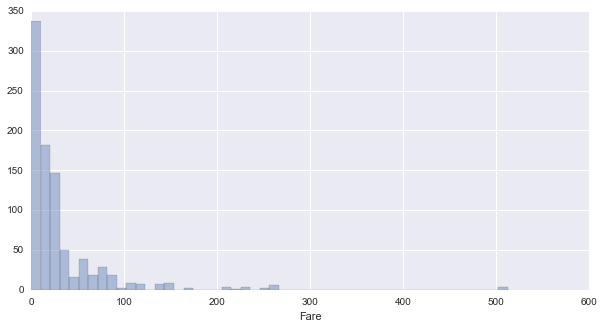

In [9]:
#Set larger figure size (with matplotlib)
plt.figure(figsize=(10,5))
#Plotting (with seaborn)
sns.distplot(df['Fare'],kde = False)

The distribution of the data is quite skewed to the right, there is also a distinct outlier that will make mean value higher, so it makes sense to work with median value to determine the typical fare.

Let's see what is the median fare for 1st class tickets for each embarkation port

In [10]:
df[df['Pclass'] ==1].groupby('Embarked')['Fare'].median()

Embarked
C    78.2667
Q    90.0000
S    52.0000
Name: Fare, dtype: float64

The fare paid is close to fair normally paid for 'C' embarkation port, so we fill missing values in our cells with 'C' port

In [11]:
df.set_value(62, 'Embarked','C')
df.set_value(830, 'Embarked','C')

#Checking if there still any missing values left in out dataframe
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Last_name     0
First_name    0
dtype: int64

We also create a new column ['Family'] which sums ['SibSp'] and ['Parch'] columns. 
This new column might be of use to us while answering Q4 from our question list and to create it we use vectorized 
operation on two existing columns from our dataframe

In [12]:
df['Family'] = df['SibSp'] + df['Parch']

For the purposes of this analysis and specifically for being able to reply our Q3, we modify ['Sex'] column adding 
new category 'child' for passengers under 15 y.o.

In [13]:
df.loc[df['Age']<=15, 'Sex'] = 'child'

### Data Exploration

We start off with drawing a scatter matrix for each pair of variables, seaborn provides a `PairPlot()` option to achieve that.

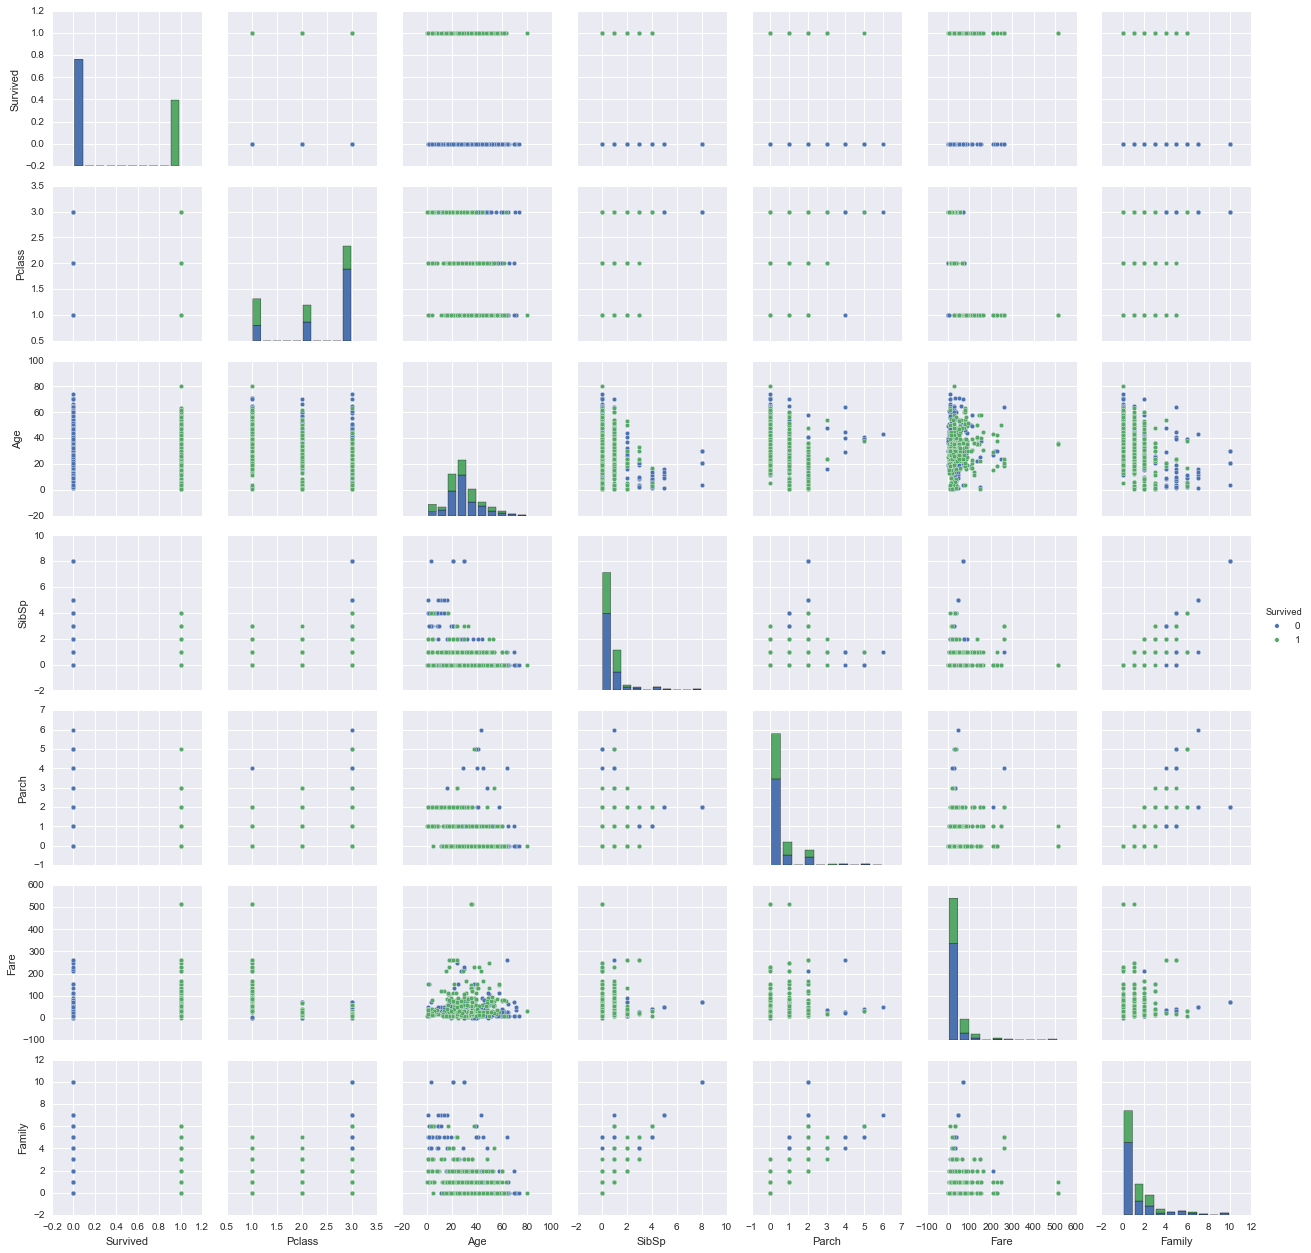

In [14]:
sns.pairplot(df, hue = 'Survived')

The scatter matrix allow us to see some basic information : passengers age is mostly between 20 and 40, most people travelled third class, passengers travelling in large families mostly did not survive, older people mostly travel with fewer family members and so on. 

Let's also build a correlation matrix (calculate Pearson's r for each pair of numeric variables in our dataframe) to get the basic understanding of how our variables correlate with each other. 

We calculate correlation only for numeric data, therefore in addition to ['Sex'],['Title'],['First_name'] and ['Last_name'] columns, which were not included automatically as their contents contain non-integers, we exclude our categorical variables ['Survived'] and ['Pclass'] from the correlation matrix as Pandas might treat them as numeric data and calculation results might be misleading. We utilize  Pandas built-in function `corr()` for our calculations. 

In [15]:
df[df.columns[3:]].corr('pearson')

,Age,SibSp,Parch,Fare,Family
Age,1.000000,-0.265602,-0.188122,0.097944,-0.275513
SibSp,-0.265602,1.000000,0.414838,0.159651,0.890712
Parch,-0.188122,0.414838,1.000000,0.216225,0.783111
Fare,0.097944,0.159651,0.216225,1.000000,0.217138
Family,-0.275513,0.890712,0.783111,0.217138,1.000000


We see some slight negative correlation between ['Age'] and ['Family'] variables, slight positive correlation between ['Family'] and ['Fare'] and relatively strong positive correlation between ['Parch'] and ['SibSp'] variables. 

Now let's directly dive in our data exploration and answer posed Qs one by one

### 1. Did the travelling class make passengers more likely to survive?


To answer this question we use Pansdas `groupby()` function to group passengers according to the class and `size()` calculate percentage of passngers survived and did not survived in each Pclass. We also visualize our data in seaborn using `countplot()`

Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
dtype: float64


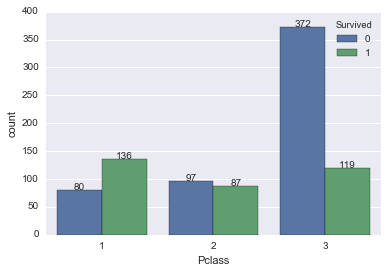

In [16]:

df.groupby(['Pclass', 'Survived']).size()
gr = df.groupby(['Pclass', 'Survived']).size()
print gr / gr.groupby(level=0).sum()

#visualizing absolute numbers too
plot = sns.countplot(x = 'Pclass', hue = 'Survived', data = df)
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,height,'%d'%(height),ha="center") 

And looks like the passenger class is one of the factors that made people likely to survive, as 136 out of 216 (about 63%) 1st class passenegers survived, whereas for 2d and 3d class this percentage is substantially lower : 47% and 24% respectively.

Now let's move on to answering the second question from our question list:
### 2. Were adults / children more likely to survive than the old passengers ?

We take a look on our ['Age'] column.
First get some basic statistic on passenger ages and visualize the distribution of the data.

In [17]:
df['Age'].describe()

count    891.000000
mean      29.390202
std       13.265322
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

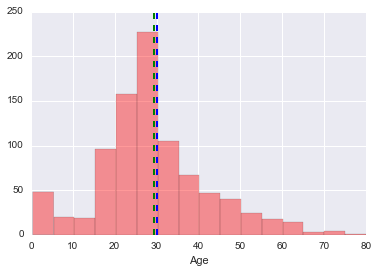

In [18]:
plot = sns.distplot(df['Age'],bins = 16, kde = False, color = 'red')

#Draw the mean and the median of the distribution
plot.axvline(df['Age'].mean(), color='g', linestyle='dashed', linewidth=2)
plot.axvline(df['Age'].median(), color='b', linestyle='dashed', linewidth=2)

The distribution of the age values is a bit skewed to the right, with a distinct peak between 25 - 30, average at 29.39 and center of the distribution a bit further to the left, around 29.

Let's modify our histo to see breakup of survivors and non-survivors for each age

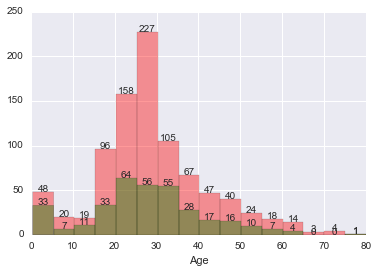

In [19]:
plot1 = sns.distplot(df['Age'],bins = 16, kde = False,  color = 'red')
plot2 = sns.distplot(df['Age'][df['Survived'] == 1], bins = 16, kde = False, color = 'green')

for p2 in plot2.patches:        
    height2 = p2.get_height()
    plot2.text(p2.get_x() + p2.get_width()/2.,height2,'%d'%(height2),ha="center") 

Seems like children under 15 y.o. and young people between 20 - 35 y.o. account for the biggest part of the survivors, while the survival chances for older people of age above 60 y.o. seems to be way lower. Let's calculate the fraction of survivors for three age groups: children(age: 0 - 15), adults (15 - 59), old people (>60). 

In [41]:
#procedure that calculate percentage:
def calculate_fraction (value1, value2, fraction_description):
    result = float(value1) / value2
    print "Percentage of", fraction_description, "is {}%".format("%.2f" % round(result*100,2))

calculate_fraction(df['Survived'][df['Age'] >=60][df['Survived'] == 1].count(),
                   df['Survived'][df['Age']>=60].count(),
                   'old people survived')
calculate_fraction(df['Survived'][df['Age'] <60][df['Age']>15][df['Survived'] == 1].count(),
                   df['Survived'][df['Age']<60][df['Age']>15].count(),
                  'adults survived')
calculate_fraction(df['Survived'][df['Age'] <=15][df['Survived'] == 1].count(),
                   df['Survived'][df['Age']<=15].count(),
                   'children survived')

Percentage of old people survived is 26.92%
Percentage of adults survived is 36.50%
Percentage of children survived is 58.62%


Indeed survival fraction for children is way higher than for other two age groups, while the older people still have lower chances for survival comparing to adults. 

Now let's explore if there is a trend between passenger class and age (maybe older people prefer saving money and travelled lower class and that caused lower survival for this age group)

Pclass
1    37.309815
2    29.787120
3    25.757475
Name: Age, dtype: float64


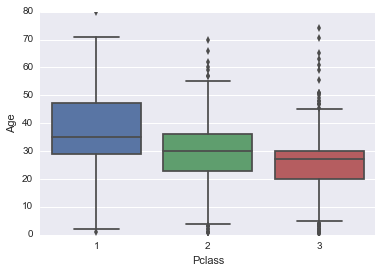

In [21]:
#Average age for passengers of each class
print df['Age'].groupby(df['Pclass']).mean()

#Drawing the boxplot to see average age for different travelling class more clearly
sns.boxplot(x="Pclass", y="Age", data=df)

On the contrary, the average age of the passengers increase with higher class. Let's add ['Survived'] variable to draw further conclusions on survival chances for passengers of different age and travelling class.

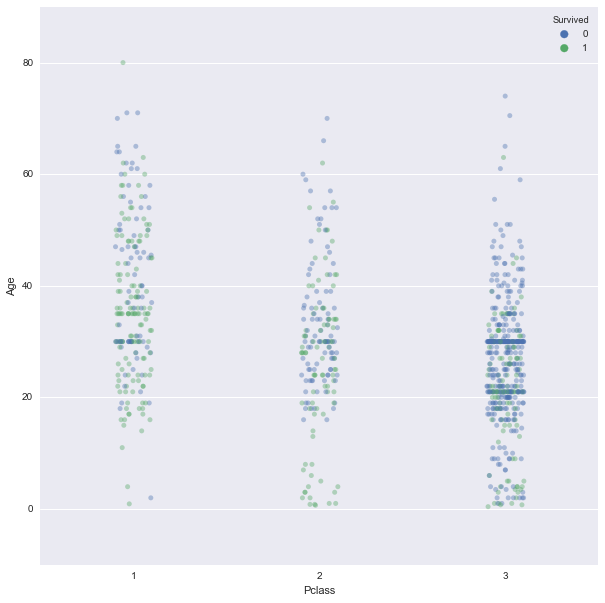

In [22]:
#We add some jitter to the scatterplot, increase the size to make it more readable and adjust alpha param to be able to 
#see where most of the datapoints are located on the plot
plt.figure(figsize=(10,10))
sns.stripplot('Pclass', 'Age',
           data=df,
           hue="Survived", jitter = .1, alpha = .4)

Just as our statistic told us, there are more people with age >60y.o. in the first class than in 2d and 3d, and considering what we observed above, it looks like older people have lower chances for survival, regardless of the class they travelled (even among the 1st class passengers with the highest percentage of survivors, the age of survived passengers is mostly below 40, while the biggest part of passengers over 60 in all three classes did not survive)

### 3. Did passenger gender contributed to survival likelyhood ?

Our assumption (which is based on the famous movie with Leonardo DiCaprio:))) is that during the ship crush women and children mostly survived because they should have been saved first, so let's  check if this guess is correct! 

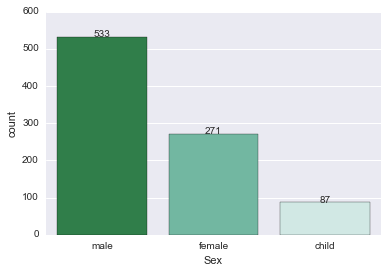

In [23]:
#First let's see how many people in our gender groups and the number of children
plot = sns.countplot(x = 'Sex', data = df, palette = 'BuGn_r')
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,
                height,
                '%d'%(height),
                ha="center") 

The biggest part of the passengers are men (533), while women account for less than half of that number (271), and children is the least numerous among the three groups with 87 passengers belong to it. 

Next we build a barplot to visualize the survivors in each of the categories.

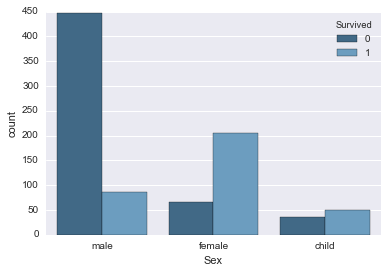

In [24]:
sns.countplot(x = 'Sex', hue = 'Survived', data = df, palette = 'Blues_d')

Seems like our assumption is totally valid and women and children had far more chances to survive the Titanic crush than men. 

Let's explore is there any trend between ['Age'] and ['Sex'] variables for the passengers, maybe older men tend to travel more than older women, or maybe the latter are more adventurous ?:)

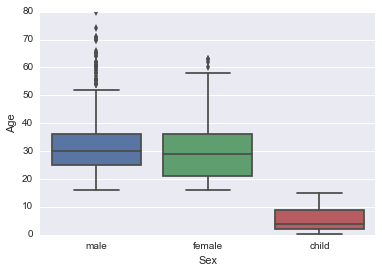

In [25]:
sns.boxplot(x="Sex", y="Age", data=df)

Indeed most of the passengers above 60 y.o. are men while there were only few female passengers whose age exceeds 60 y.o., however the average age for both men and women is almost the same. Let's add ['Pclass'] variable and check the class preferances for passengers of different ages in different gender groups.

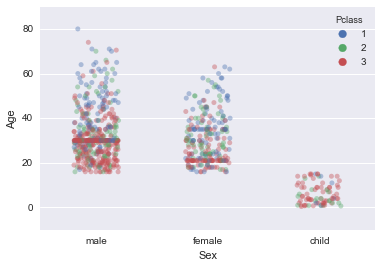

In [26]:
sns.stripplot(x="Sex", y="Age", data=df, jitter = .2, hue = 'Pclass', alpha = .4)

Looks like male passengers do prefer to save money and travel 3d class (specifically male between 20 and 40 y.o.), while female passengers probably more demanding so they seem to travel more in 1st or 2d class, whereas only the youngest women around 20 y.o. still tend to choose 3d class travel. 

Assuming that children were travelling the same class as their parents, most of the families with kids were travelling 3d class. 

To double check this assumption, we make bivariate barplot for gender groups and passenger class

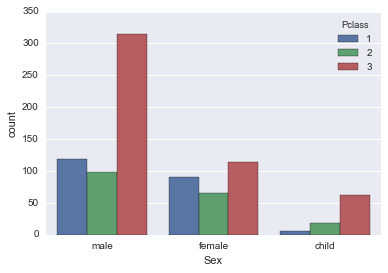

In [27]:
plot = sns.countplot(x = 'Sex', hue = 'Pclass', data = df)

Just as we concluded above !

Now let's answer the last Q before drawing final conclusions

### 4. Were people travelling with family (children or spouse) likely to survive than for passengers travelling alone?

For starters let's see the distribution of the data in our ['Family'] column

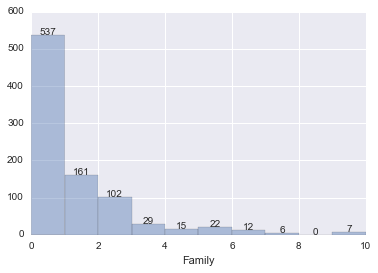

In [28]:
plot = sns.distplot(df['Family'],bins = 10, kde = False)
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,height,'%d'%(height),ha="center") 

537 passengers (about 60% of the total) where travelling alone, while 263 (some 29.5%) were travelling with 1-2 family members and the remaining passengers, which is about 10.5% where travelling with more than 2 family members. 

We visualize the same data but in context of survival the crush by adding ['Survived'] variable to our barplot and see if small families had more chances for survival than big ones.

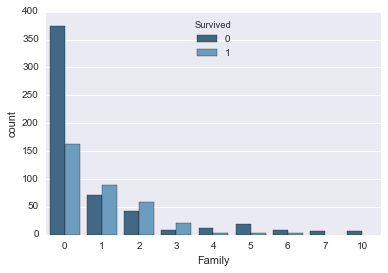

In [29]:
sns.countplot(x = 'Family', hue = 'Survived', data = df, palette = 'Blues_d')

Looks like they did! As per the barplot above, passengers travelling with more than 3 family members mostly did not survive the crush, while singletons and small families (not more than 3 family members) had fair chances for survival

Finally let's also make breakup by passenger class for singletons and families.

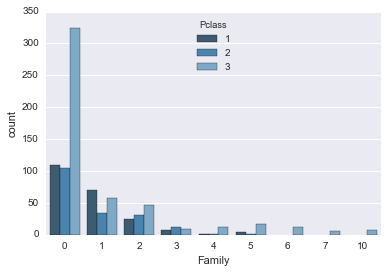

In [30]:
sns.countplot(x = 'Family', hue = 'Pclass', data = df, palette = 'Blues_d')

Singletons tend to travel 3d class, however a lot of them still go for 1st and 2d classes. Small families with family members up to 3 seem to have no distinct preferance for the class they travel (the distribution of the data is uniform for them), while big families with more than 3 members obviously were likely to choose 3d class more often than others. 

### Drawing conclusions

After exploring variables in our dataset we concluded that factors that contribute to higher likelyhood of passengers survival on Titanic were as following :

- Travelling class. 
1st class passengers were more likely to survive than 3d class

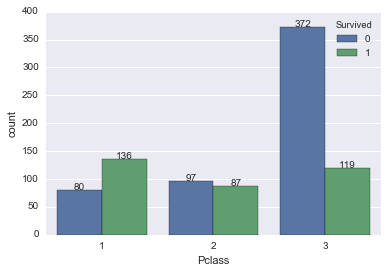

In [31]:
plot = sns.countplot(x = 'Pclass', hue = 'Survived', data = df)
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,height,'%d'%(height),ha="center") 

- Gender. 
Women and children chances for survival were considerably higher then men 

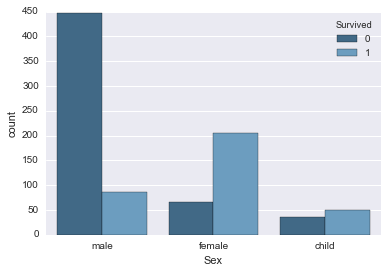

In [32]:
sns.countplot(x = 'Sex', hue = 'Survived', data = df, palette = 'Blues_d')

- Age. Children and people under 60 y.o. comprise the main part of Titanic survivors, while older people over 60 y.o. had way lower chances for survival (even among the 1st class passengers with the highest percentage of survivors,people over 60 y.o. mostly did not survive)

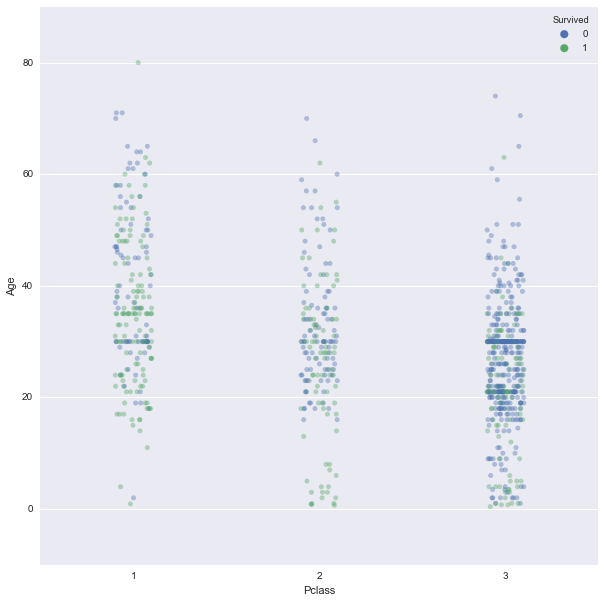

In [33]:
plt.figure(figsize=(10,10))
sns.stripplot('Pclass', 'Age',
           data=df,
           hue="Survived", jitter = .1,alpha =.4)

- Family size. People travelling alone and small families with 1 -2 family members were more likely to survive the crush than big families with more than 2 family members.

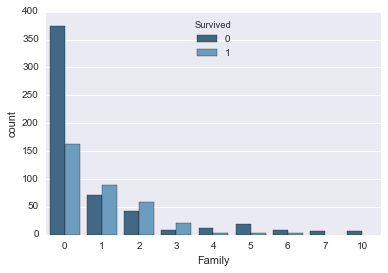

In [34]:
sns.countplot(x = 'Family', hue = 'Survived', data = df, palette = 'Blues_d')

### Sources used in the analysis:

1. Counting empty cells in Pandas dataframe https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame 

2. Handling missing values in Pandas https://chrisalbon.com/python/pandas_missing_data.html

3. Very gentle introduction to regular expressions in Python  https://docs.python.org/2/howto/regex.html#regex-howto

4. Removing text in parens https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex

5. Set value for particular cell http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.set_value.html

6. Seaborn documentation for `countplot()` https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial

7. How to count the percentage of group size in Pandas https://stackoverflow.com/questions/37404392/pandas-count-percentage-of-group-size

8. Seaborn documentation for histograms https://seaborn.pydata.org/tutorial/distributions.html

9. Draw mean and median lines on histogram https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib

10. Make annotations in histogram https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn   

11. Calculate mean for each group in Pandas.groupby() https://chrisalbon.com/python/pandas_apply_operations_to_groups.html